In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd
import seaborn as sns

In [1]:
import datasets
from transformers import AutoTokenizer

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniconda3/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [16]:
test = datasets.load_from_disk("./data/tokenized/crasp_variants/shuffle_spans_4_nd/")

In [17]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m")

# Loss curves

In [2]:
def download_loss_from_wandb(project_path, run_name, metric="train/loss"):
    """Downloads complete loss data from a W&B run by project path and run name.

    Args:
        project_path: The path to the W&B project (e.g., "username/project").
        run_name: The name of the W&B run (e.g., "my_run").
        metric: The name of the metric to download (default: "loss").

    Returns:
        A pandas DataFrame containing the loss data, or None if an error occurs.
    """
    try:
        api = wandb.Api()

        # Find the run by name within the project
        runs = api.runs(project_path, filters={"displayName": run_name})

        if not runs:
            print(f"No run found with name '{run_name}' in project '{project_path}'")
            return None

        if len(runs) > 1:
            print(f"Multiple runs found with name '{run_name}' in project '{project_path}'. Please use run id instead.")
            for run in runs:
                print(f"Run ID: {run.id}")
            return None

        run = runs[0]

        # Use scan_history() to get the complete history
        history = run.scan_history()
        data = []
        for row in history:
            data.append(row)

        if len(data) == 0:
          print(f"No history data found for run {run.path}")
          return None

        df = pd.DataFrame(data)

        df[metric] = df[metric].ffill()

        if metric not in df.columns:
            print(f"Metric '{metric}' not found in run {run.path}")
            print(f"Available metrics: {df.columns}")
            return None

        return df[["_step", metric]].dropna(subset=[metric])

    except wandb.CommError as e:
        print(f"WandB Communication Error: {e}")
        print("Check your internet connection and W&B API key.")
        return None
    except Exception as e:
        print(f"{run_name} An error occurred: {e}")
        return None

In [4]:
raw_data = []

for language in ["dyck_v2", "rep", "cross"]:
    for iters in [500]:
        for seed in [0, 1, 2]:
            raw_data.append([language, iters, seed, download_loss_from_wandb("myhu/huggingface", f"./output/scaling_laws_transfer/c4/pythia-160m/{language}-{iters}-lr5e4-{seed}")['train/loss'].to_numpy()])

In [100]:
raw_data = []

for seed in [0, 1, 2]:
    raw_data.append([seed, download_loss_from_wandb("myhu/huggingface", f"./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-{seed}")['train/loss'].to_numpy()])

In [5]:
df = pd.DataFrame(raw_data, columns=["language", "iters", "seed", "loss_curve"])

In [6]:
df.to_pickle("loss_curves_chomsky.pkl")

In [9]:
def calculate_average_loss_and_std(loss_curves, smoothing_factor=0.9):
    """Calculates the average loss and standard deviation over multiple runs.

    Args:
        loss_curves: A list of lists or a 2D numpy array. Each inner list/row
                     represents a loss curve over epochs/iterations.

    Returns:
        A tuple containing:
            - epochs: A 1D numpy array of epoch/iteration numbers.
            - average_loss: A 1D numpy array of the average loss at each epoch.
            - std_dev_loss: A 1D numpy array of the standard deviation of the loss at each epoch.
        Raises:
          ValueError: If loss_curves is empty or if the inner lists have inconsistent lengths.
    """

    if np.any(np.diff([len(curve) for curve in loss_curves]) != 0): #check for different lengths
        raise ValueError("Inner lists in loss_curves must have the same length.")

    epochs = np.arange(loss_curves.shape[1])
    average_loss = np.mean(loss_curves / 2, axis=0)
    std_dev_loss = np.std(loss_curves / 2, axis=0)

    # Calculate EMA
    ema_loss = np.zeros_like(average_loss)
    ema_loss[0] = average_loss[0]  # Initialize the first value
    for i in range(1, len(average_loss)):
        ema_loss[i] = smoothing_factor * ema_loss[i-1] + (1 - smoothing_factor) * average_loss[i]
    
    return epochs, average_loss, std_dev_loss, ema_loss


def plot_loss_with_error_band(epochs, average_loss, std_dev_loss, ax, label=None, color=None, linewidth=1.0):
    """Plots the average loss curve with an error band.

    Args:
        epochs: A 1D numpy array of epoch/iteration numbers.
        average_loss: A 1D numpy array of the average loss at each epoch.
        std_dev_loss: A 1D numpy array of the standard deviation of the loss at each epoch.
        ax: A matplotlib Axes object to plot on.
        label: (Optional) A label for the plot.
        color: (Optional) Color for the plot.
    """
    if color is None:
        sns.lineplot(x=epochs, y=average_loss, ax=ax, label=label, linewidth=linewidth)
    else:
        sns.lineplot(x=epochs, y=average_loss, ax=ax, label=label, color=color, linewidth=linewidth)

    # ax.fill_between(epochs, average_loss - std_dev_loss, average_loss + std_dev_loss, alpha=0.3, color=color)

In [107]:
def plot_fig(df, language, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    for iter in [500, 1000, 2000, 4000]:
        raw_data = df[(df['language'] == language) & (df['iters'] == iter)]['loss_curve'].to_numpy()
        data = np.array([list(x) for x in raw_data])
    
        x, y, yerr, y_ema = calculate_average_loss_and_std(data)
        print(iter, np.mean(y[-5:]))
    
        plot_loss_with_error_band(x, y_ema, yerr, ax, label=iter)
    
    ax.set_ylim(3.7, 4.2)
    ax.set_title(title)
    return ax

In [21]:
baseline_df = pd.read_pickle("loss_curves_baseline.pkl")
synthetics_df = pd.read_pickle("loss_curves_synthetics.pkl")
chomsky_df = pd.read_pickle("loss_curves_chomsky.pkl")

2.8606070211961674
3.2183055972056165
3.186881589964872


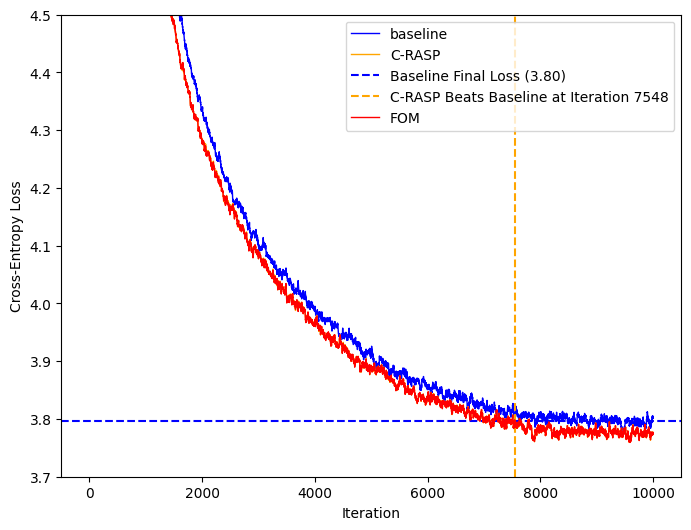

In [23]:
# Figure 1: PPT on synthetic speeds up by 3k steps

smoothing_factor = 0.95

fig, ax = plt.subplots(figsize=(8, 6))
raw_data = baseline_df['loss_curve'].to_numpy()
data = np.array([list(x) for x in raw_data])
print(np.var(data))

x, y, yerr, y_ema = calculate_average_loss_and_std(data, smoothing_factor=smoothing_factor)
plot_loss_with_error_band(x, y_ema, yerr, ax, label="baseline", color="blue")

final_y = np.mean(y[-10:]) if len(y)>=10 else np.mean(y) #handle cases where the length of y is less than 10

raw_data = synthetics_df[(synthetics_df['language'] == "crasp_100k") & (synthetics_df['iters'] == 500)]['loss_curve'].to_numpy()
data = np.array([list(x) for x in raw_data])
print(np.var(data))

x, y_crasp, yerr, y_crasp_ema = calculate_average_loss_and_std(data, smoothing_factor=smoothing_factor)
plot_loss_with_error_band(x, y_crasp_ema, yerr, ax, label="C-RASP", color='orange')

ax.set_ylim(3.7, 4.5)
ax.set_ylabel("Cross-Entropy Loss")
ax.set_xlabel("Iteration")

# Horizontal dashed line for baseline final loss
ax.axhline(y=final_y, color='blue', linestyle='--', label=f"Baseline Final Loss ({final_y:.2f})")

# Find the iteration where C-RASP first beats the baseline final loss
first_beat_index = np.where(y_ema < final_y)[0]
if len(first_beat_index) > 0:
    first_beat_iteration = x[first_beat_index[0]]
    ax.axvline(x=first_beat_iteration, color='orange', linestyle='--', label=f"C-RASP Beats Baseline at Iteration {first_beat_iteration}")

raw_data = synthetics_df[(synthetics_df['language'] == "fom") & (synthetics_df['iters'] == 500)]['loss_curve'].to_numpy()
data = np.array([list(x) for x in raw_data])
print(np.var(data))

x, y_fom, yerr, y_fom_ema = calculate_average_loss_and_std(data, smoothing_factor=smoothing_factor)
plot_loss_with_error_band(x, y_fom_ema, yerr, ax, label="FOM", color='red')

ax.legend()
# plt.show()

In [33]:
raw_data = chomsky_df[(chomsky_df['language'] == "cross") & (chomsky_df['iters'] == 500)]['loss_curve'].to_numpy()
data = np.array([list(x) for x in raw_data])

x, y_cross, yerr, y_cross_ema = calculate_average_loss_and_std(data, smoothing_factor=smoothing_factor)
print(np.mean(y_cross[-10:]))

3.760938333333333


In [29]:
raw_data = synthetics_df[(synthetics_df['language'] == "dyck") & (synthetics_df['iters'] == 500)]['loss_curve'].to_numpy()
data = np.array([list(x) for x in raw_data])
print(np.var(data))

x, y_dyck, yerr, y_dyck_ema = calculate_average_loss_and_std(data, smoothing_factor=smoothing_factor)
print(np.mean(y_dyck[-10:]))

3.7742216666666666

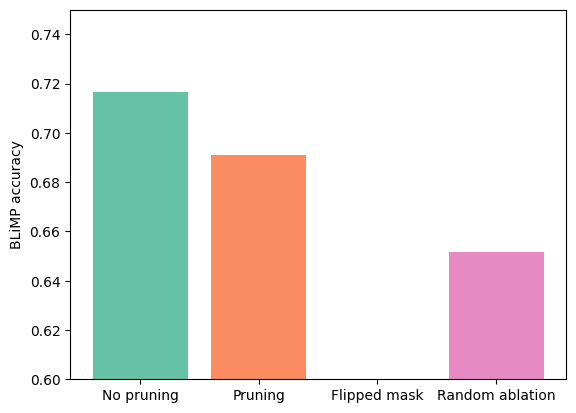

In [45]:
# Figure 2: Subnetwork ablations on BLiMP

conditions = ["No pruning", "Pruning", "Flipped mask", "Random ablation"]
accuracies = [0.7163880597, 0.6909402985, 0, 0.6517671642]

# Choose a qualitative Seaborn color palette
# Refer to: https://seaborn.pydata.org/tutorial/color_palettes.html
# Other good options: "Set1", "Set2", "Set3", "pastel", "muted", "bright", "dark", "colorblind"
colors = sns.color_palette("Set2")  # Example: Using the "tab10" palette

# Create the bar plot with specified colors
fig, ax = plt.subplots()
ax.bar(conditions, accuracies, color=colors)

# Set labels and title
ax.set_ylabel("BLiMP accuracy")
ax.set_ylim(0.6, 0.75)
# Display the plot
plt.show()

In [59]:
def visualize_binary_matrix(matrix, title=None):
    """
    Visualizes a binary matrix with black representing 0 and white representing 1.
    Flips the matrix vertically so the first row is on the bottom.

    Args:
        matrix: A 2D numpy array representing the binary matrix.
    """

    fig, ax = plt.subplots()
    # Flip the matrix vertically using np.flipud()
    flipped_matrix = np.flipud(matrix)
    im = ax.imshow(flipped_matrix, cmap="binary", interpolation="nearest")

    # Set ticks and labels, adjusting for the flipped matrix
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))
    ax.set_xticklabels(np.arange(1, matrix.shape[1] + 1))
    # The y-tick labels need to be reversed to match the flipped data
    ax.set_yticklabels(np.arange(matrix.shape[0], 0, -1))

    # Create a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=10, label='Ablated'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='w', markersize=10, label='Kept')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

    # Add a title
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [57]:
matrix = np.load("./output/prune/crasp_100k/pythia-160m/0/checkpoint-500/aggregated_params.npy")
binary_matrix = matrix < 0

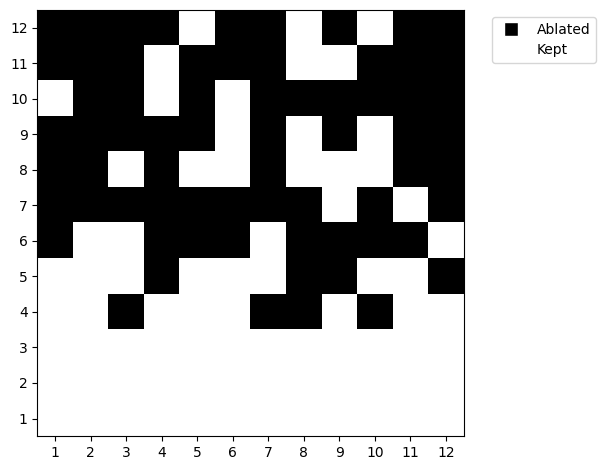

In [60]:
visualize_binary_matrix(binary_matrix)

# BLiMP

In [22]:
def get_blimp_scores(model_dir):
    x = []
    y = []

    for dir in glob.glob(model_dir + "/*"):
        t = dir.split("/")[-1].split("-")[-1]
        try:
            with open(os.path.join(dir, "blimp.json"), 'r') as file:
                content = file.read().strip()
                number = float(content)
                x.append(int(t))
                y.append(number)
        except:
            print(dir)

    x = np.array(x)
    y = np.array(y)
    
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    return x, y

In [23]:
x_crasp, y_crasp = get_blimp_scores("./output/scaling_laws_transfer/c4/pythia-160m/crasp_100k-500-lr5e4-0")

In [24]:
x, y = get_blimp_scores("./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/")

./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-700loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-1300loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-800loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-3300loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-3900loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-600loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-100loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-2400loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-2000loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-1700loss.json
./output/scaling_laws_transfer/baseline/pythia-160m/c4-lr5e4-0/checkpoint-3200loss.json
./output/scaling_laws_transfer/basel

In [19]:
y

array([0.54513433, 0.54373134, 0.54758209, 0.56271642, 0.58034328,
       0.59102985, 0.5948806 , 0.60029851, 0.60265672, 0.6188806 ,
       0.63662687, 0.64316418, 0.63374627, 0.6489403 , 0.65153731,
       0.65358209, 0.65265672, 0.66031343, 0.66561194, 0.66879104,
       0.67364179, 0.66820896, 0.67804478, 0.67743284, 0.68201493,
       0.68532836, 0.68602985, 0.68410448, 0.6890597 , 0.69316418,
       0.69379104, 0.69026866, 0.6910597 , 0.69685075, 0.69832836,
       0.6960597 , 0.69214925, 0.69762687, 0.70043284, 0.71565672])

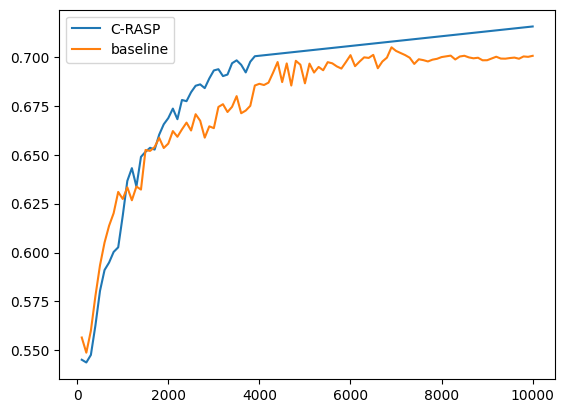

In [26]:
plt.plot(x_crasp, y_crasp, label="C-RASP")
plt.plot(x, y, label="baseline")
plt.legend()

# Pruned metrics

In [26]:
file_dir = "./output/scaling_laws_transfer/c4/pythia-160m/dyck-500-lr5e4-0/checkpoint-10000/"
with open(file_dir + "loss_True_aggregated_params.json", "r") as file:
    data_str = file.read().strip("[]\n")

data = np.fromstring(data_str, sep=",")
print(np.mean(data))

3.98351207037922


In [ ]:
# loss_True_aggregated_params.json